In [1]:
## Initial Analysis of Low Grade (IDH1 Mutant) Glioma basic data from NIH NCI GDC Data Portal

# Load Packages for managing and plotting data
# If using local environment may need to install using command-line, like "pip install scikit-learn"

import os
import requests
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
import sklearn

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px

In [2]:
# Discover field mapping for endpoints, such as cases, ssms, gene, for displaying/ filtering like on project, gene symbol...
# Can use GDC Data Dictionary Viewer at https://docs.gdc.cancer.gov/Data_Dictionary/viewer/

url_main = "https://api.gdc.cancer.gov/"
endpoint = "ssm_occurrences/_mapping"
endpoint_url = url_main + endpoint
params = {"pretty":True}

response = requests.get(endpoint_url, params = params)

# View output
print(response.url)
# print(json.dumps(response.json(), indent=2))

https://api.gdc.cancer.gov/ssm_occurrences/_mapping?pretty=True


In [3]:
# Example for downloading file based on UUID from GDC URL
# This and previous mapping snippet can be used to test GDC API connection

file_endpt = 'https://api.gdc.cancer.gov/files/'
file_uuid = 'f3a1bc62-9552-4553-b318-7d9c21d21ce7'
params = {"pretty":True}

response = requests.get(file_endpt + file_uuid, params=params)

# OUTPUT METHOD 1: Write to a file.
file = open("input/sample_file.json", "w")
file.write(response.text)
file.close()

# OUTPUT METHOD 2: View on screen.
print(response.url)
print(json.dumps(response.json(), indent=2))

https://api.gdc.cancer.gov/files/f3a1bc62-9552-4553-b318-7d9c21d21ce7?pretty=True
{
  "data": {
    "data_format": "BCR Biotab",
    "access": "open",
    "file_name": "nationwidechildrens.org_clinical_patient_lgg.txt",
    "submitter_id": "nationwidechildrens.org_clinical_patient_lgg.txt",
    "data_category": "Clinical",
    "acl": [
      "open"
    ],
    "type": "clinical_supplement",
    "file_size": 351218,
    "created_datetime": "2018-05-21T22:14:34.066432-05:00",
    "md5sum": "00dcd9b02d7bdc39909d4b05072a53fa",
    "updated_datetime": "2018-11-01T15:06:10.843096-05:00",
    "file_id": "f3a1bc62-9552-4553-b318-7d9c21d21ce7",
    "data_type": "Clinical Supplement",
    "state": "released",
    "version": "1",
    "data_release": "12.0 - 37.0"
  },
  "warnings": {}
}


In [4]:
# Filtered Query via GDC using "cases" endpoint, not good for queries on somatic gene symbol mutations

# Build query criteria to match
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.primary_site",
            "value": ["Brain"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.disease_type",
            "value": ["Gliomas"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "project.project_id",
            "value": ["TCGA-LGG"]
            }
        } # TODO: Use ssm_occurrences for filtering based on somatic gene symbol
    ]
}

# Specify fields GDC to return
fields = [
    "case_id",
    "demographic.gender",
    "demographic.vital_status",
    "demographic.year_of_birth",
    "demographic.year_of_death",
    "diagnoses.age_at_diagnosis",
    "diagnoses.days_to_recurrence",
    "diagnoses.primary_diagnosis", # Astrocytoma, Glioblastoma, Mixed Glioma and Oligodendroglioma
    "diagnoses.site_of_resection_or_biopsy", # Brain, Frontal lobe, Temporal lobe, Parietal lobe...
    "diagnoses.tumor_grade", # Not seeing much data, mostly "Not Reported"
    "project.project_id", # CPTAC-3, TCGA-GBM, TCGA-LGG...
    "summary.file_count"
    ]

fields = ",".join(fields)

# Build and execute GET request
endpoint = "https://api.gdc.cancer.gov/cases"

# With a GET request, the filters parameter needs to be converted
# from a dictionary to JSON-formatted string

params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "CSV",
    "size": "500",
    "pretty": True
    }

response = requests.get(endpoint, params = params)

# Write to a file
file = open("input/cases_query.CSV", "w")
file.write(response.text)
file.close()

# View output
print(response.url)
#print(response.text)

https://api.gdc.cancer.gov/cases?filters=%7B%22op%22%3A+%22and%22%2C+%22content%22%3A+%5B%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22cases.primary_site%22%2C+%22value%22%3A+%5B%22Brain%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22cases.disease_type%22%2C+%22value%22%3A+%5B%22Gliomas%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22project.project_id%22%2C+%22value%22%3A+%5B%22TCGA-LGG%22%5D%7D%7D%5D%7D&fields=case_id%2Cdemographic.gender%2Cdemographic.vital_status%2Cdemographic.year_of_birth%2Cdemographic.year_of_death%2Cdiagnoses.age_at_diagnosis%2Cdiagnoses.days_to_recurrence%2Cdiagnoses.primary_diagnosis%2Cdiagnoses.site_of_resection_or_biopsy%2Cdiagnoses.tumor_grade%2Cproject.project_id%2Csummary.file_count&format=CSV&size=500&pretty=True


In [5]:
# Filtered Query via GDC using "ssm_occurences" endpoint

# Build query criteria to match
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "case.project.project_id",
            "value": ["CPTAC-3", "TCGA-GBM", "TCGA-LGG"]
            }
        },
        {
        "op": "=",
        "content":{
            "field": "ssm.consequence.transcript.gene.symbol",
            "value": ["IDH1"]
            }
        },
        {
        "op": "=",
        "content":{
            "field": "case.primary_site",
            "value": ["Brain"]
            }
        },
        {
        "op": "=",
        "content":{
            "field": "case.disease_type",
            "value": ["Gliomas"]
            }
        }
    ]
}

# Specify fields GDC to return
fields = [
    "case.case_id",
    "case.demographic.gender",
    "case.demographic.vital_status",
    "case.demographic.year_of_birth",
    "case.demographic.year_of_death",
    "case.diagnoses.age_at_diagnosis",
    "case.diagnoses.days_to_recurrence",
    "case.diagnoses.primary_diagnosis", # Astrocytoma, Glioblastoma, Mixed Glioma and Oligodendroglioma
    "case.diagnoses.site_of_resection_or_biopsy", # Brain, Frontal lobe, Temporal lobe, Parietal lobe...
    "case.diagnoses.tumor_grade", # Not seeing much data, mostly "Not Reported"
    "case.project.project_id", # CPTAC-3, TCGA-GBM, TCGA-LGG...
    "ssm.gene_aa_change",
    "ssm.genomic_dna_change"
    ]

fields = ",".join(fields)

# Build and execute GET request
endpoint = "https://api.gdc.cancer.gov/ssm_occurrences"

# With a GET request, the filters parameter needs to be converted
# from a dictionary to JSON-formatted string

params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "CSV",
    "size": "500",
    "pretty": True
    }

response = requests.get(endpoint, params = params)

# Write to a file
file = open("input/ssm_occurrences_query.CSV", "w")
file.write(response.text)
file.close()

# View output
print(response.url)
#print(response.text)

https://api.gdc.cancer.gov/ssm_occurrences?filters=%7B%22op%22%3A+%22and%22%2C+%22content%22%3A+%5B%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.project.project_id%22%2C+%22value%22%3A+%5B%22CPTAC-3%22%2C+%22TCGA-GBM%22%2C+%22TCGA-LGG%22%5D%7D%7D%2C+%7B%22op%22%3A+%22%3D%22%2C+%22content%22%3A+%7B%22field%22%3A+%22ssm.consequence.transcript.gene.symbol%22%2C+%22value%22%3A+%5B%22IDH1%22%5D%7D%7D%2C+%7B%22op%22%3A+%22%3D%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.primary_site%22%2C+%22value%22%3A+%5B%22Brain%22%5D%7D%7D%2C+%7B%22op%22%3A+%22%3D%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.disease_type%22%2C+%22value%22%3A+%5B%22Gliomas%22%5D%7D%7D%5D%7D&fields=case.case_id%2Ccase.demographic.gender%2Ccase.demographic.vital_status%2Ccase.demographic.year_of_birth%2Ccase.demographic.year_of_death%2Ccase.diagnoses.age_at_diagnosis%2Ccase.diagnoses.days_to_recurrence%2Ccase.diagnoses.primary_diagnosis%2Ccase.diagnoses.site_of_resection_or_biopsy%2Ccase.diag

In [6]:
# Data files managed in the "input" directory

for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/cases.2023-03-16.json
input/cases_query.CSV
input/.DS_Store
input/sample_file.json
input/ssm_occurrences_query.CSV
input/cases_dashboard.numbers


In [7]:
# Read file from https://portal.gdc.cancer.gov where Primary Site = 'brain' and Gene = 'IDH1'

data_norm = pd.read_csv(response.url)
data_norm.head()

,case.case_id,case.demographic.gender,case.demographic.vital_status,case.demographic.year_of_birth,case.demographic.year_of_death,case.diagnoses.0.age_at_diagnosis,case.diagnoses.0.days_to_recurrence,case.diagnoses.0.primary_diagnosis,case.diagnoses.0.site_of_resection_or_biopsy,case.diagnoses.0.tumor_grade,case.project.project_id,id,ssm.genomic_dna_change
0,a1192df3-7667-4d1e-a1a0-79f6cc827dcf,male,Alive,1976.0,NaN,11509.0,NaN,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,299a0097-542b-5145-a03b-a2d4b9d6959c,chr2:g.208248388C>T
1,6355cade-7b3a-43a8-9f1f-8e7bc45755a8,male,Dead,1963.0,1998.0,11584.0,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,b8a28d8d-dc5c-53f4-95d2-28ea35eb63b0,chr2:g.208248388C>T
2,607b1f22-b744-43c5-91f7-fc69142ba30e,male,Alive,1974.0,NaN,14022.0,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,69c79c57-97c5-5850-a266-ef48db2c6c0a,chr2:g.208248388C>T
3,fc3b7596-f515-446f-81db-fed0154ca2c5,female,Alive,1964.0,NaN,17432.0,NaN,"Oligodendroglioma, NOS",Cerebrum,not reported,TCGA-LGG,49d23c33-8410-5772-8416-3a414a52ac59,chr2:g.208248388C>T
4,44a5c3b4-62a7-407b-b492-7069e1a43a26,male,Dead,1960.0,2003.0,14212.0,NaN,"Astrocytoma, anaplastic","Brain, NOS",not reported,TCGA-LGG,5e42e587-2b94-57d6-b587-3c90a79b06be,chr2:g.208248388C>T


In [8]:
# Truncate column names, removing all content before and including last period

import re

rename_pattern = r'.*\.' # removed everything until last period in name
data_new = data_norm.rename(columns=lambda col_name: re.sub(rename_pattern, '', col_name))
data_new.head()

,case_id,gender,vital_status,year_of_birth,year_of_death,age_at_diagnosis,days_to_recurrence,primary_diagnosis,site_of_resection_or_biopsy,tumor_grade,project_id,id,genomic_dna_change
0,a1192df3-7667-4d1e-a1a0-79f6cc827dcf,male,Alive,1976.0,NaN,11509.0,NaN,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,299a0097-542b-5145-a03b-a2d4b9d6959c,chr2:g.208248388C>T
1,6355cade-7b3a-43a8-9f1f-8e7bc45755a8,male,Dead,1963.0,1998.0,11584.0,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,b8a28d8d-dc5c-53f4-95d2-28ea35eb63b0,chr2:g.208248388C>T
2,607b1f22-b744-43c5-91f7-fc69142ba30e,male,Alive,1974.0,NaN,14022.0,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,69c79c57-97c5-5850-a266-ef48db2c6c0a,chr2:g.208248388C>T
3,fc3b7596-f515-446f-81db-fed0154ca2c5,female,Alive,1964.0,NaN,17432.0,NaN,"Oligodendroglioma, NOS",Cerebrum,not reported,TCGA-LGG,49d23c33-8410-5772-8416-3a414a52ac59,chr2:g.208248388C>T
4,44a5c3b4-62a7-407b-b492-7069e1a43a26,male,Dead,1960.0,2003.0,14212.0,NaN,"Astrocytoma, anaplastic","Brain, NOS",not reported,TCGA-LGG,5e42e587-2b94-57d6-b587-3c90a79b06be,chr2:g.208248388C>T


In [9]:
# Convert age_at_diagnosis and days_to_death to year value

data_new['age_at_diagnosis'] = (data_new['age_at_diagnosis']/365.25).round(1)
data_new['overall_survival'] = ((data_new['year_of_death'] - data_new['year_of_birth']).round(1) - data_new['age_at_diagnosis'])

data_new.head(10)

,case_id,gender,vital_status,year_of_birth,year_of_death,age_at_diagnosis,days_to_recurrence,primary_diagnosis,site_of_resection_or_biopsy,tumor_grade,project_id,id,genomic_dna_change,overall_survival
0,a1192df3-7667-4d1e-a1a0-79f6cc827dcf,male,Alive,1976.0,NaN,31.5,NaN,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,299a0097-542b-5145-a03b-a2d4b9d6959c,chr2:g.208248388C>T,NaN
1,6355cade-7b3a-43a8-9f1f-8e7bc45755a8,male,Dead,1963.0,1998.0,31.7,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,b8a28d8d-dc5c-53f4-95d2-28ea35eb63b0,chr2:g.208248388C>T,3.3
2,607b1f22-b744-43c5-91f7-fc69142ba30e,male,Alive,1974.0,NaN,38.4,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,69c79c57-97c5-5850-a266-ef48db2c6c0a,chr2:g.208248388C>T,NaN
3,fc3b7596-f515-446f-81db-fed0154ca2c5,female,Alive,1964.0,NaN,47.7,NaN,"Oligodendroglioma, NOS",Cerebrum,not reported,TCGA-LGG,49d23c33-8410-5772-8416-3a414a52ac59,chr2:g.208248388C>T,NaN
4,44a5c3b4-62a7-407b-b492-7069e1a43a26,male,Dead,1960.0,2003.0,38.9,NaN,"Astrocytoma, anaplastic","Brain, NOS",not reported,TCGA-LGG,5e42e587-2b94-57d6-b587-3c90a79b06be,chr2:g.208248388C>T,4.1
5,106709ec-72df-44f0-8c71-87b7c755f8f0,male,Alive,1971.0,NaN,41.2,NaN,Mixed glioma,Cerebrum,not reported,TCGA-LGG,bf60c9ad-5035-5b7f-b007-344cabeb1d43,chr2:g.208248388C>T,NaN
6,b2b57e93-2722-4546-9a0b-20155b86edef,male,Dead,1983.0,NaN,30.2,NaN,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,bbac3393-5b23-5e40-bde5-e5970f4134a1,chr2:g.208248388C>T,NaN
7,2d42dd0e-be3a-46ae-a635-c6f9c52f9fa2,male,Alive,1981.0,NaN,29.1,NaN,Mixed glioma,"Brain, NOS",not reported,TCGA-LGG,265ed22d-64e6-5b07-82eb-ce314482f958,chr2:g.208248388C>T,NaN
8,0073a136-d5f4-4fd6-88f9-711768f2abc6,female,Alive,1969.0,NaN,44.7,NaN,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,3f29bd84-0dfa-56e1-8706-5afd0b44836e,chr2:g.208248388C>T,NaN
9,5a3edeb6-133e-4116-9f80-2485bd70754d,male,Alive,1982.0,NaN,27.8,NaN,"Astrocytoma, NOS",Cerebrum,not reported,TCGA-LGG,3ef30686-8498-56c4-971a-3bce5fbe805b,chr2:g.208248388C>T,NaN


In [10]:
# Handle NaN items

data_new["year_of_death"].fillna(0, inplace=True)
data_new["days_to_recurrence"].fillna(0, inplace=True)
data_new["overall_survival"].fillna(0, inplace=True)
#data_new = data_new.dropna()

data_new.tail(10)

,case_id,gender,vital_status,year_of_birth,year_of_death,age_at_diagnosis,days_to_recurrence,primary_diagnosis,site_of_resection_or_biopsy,tumor_grade,project_id,id,genomic_dna_change,overall_survival
415,86aa5790-9afd-4653-926a-625516df1f56,female,Alive,1967.0,0.0,44.6,0.0,"Astrocytoma, NOS",Cerebrum,not reported,TCGA-LGG,14185e88-fdc5-5561-854e-27b53d3917a2,chr2:g.208248388C>T,0.0
416,dcd45077-f068-490b-bdcc-4d4a62285116,female,Alive,1969.0,0.0,42.2,0.0,Mixed glioma,Cerebrum,not reported,TCGA-LGG,9dba6b31-0311-5137-a551-8c5733c457c5,chr2:g.208248388C>T,0.0
417,cb1e9916-c03f-405a-a797-15823df09c8e,male,Alive,1958.0,0.0,52.4,0.0,"Astrocytoma, anaplastic",Cerebrum,not reported,TCGA-LGG,4a974601-c5e5-563a-990b-938a63165449,chr2:g.208248388C>T,0.0
418,fb6437f9-ade8-4c33-a0d0-ceacb2bf784d,male,Alive,1973.0,0.0,38.3,0.0,"Astrocytoma, anaplastic",Occipital lobe,not reported,TCGA-LGG,2d9150c4-86a7-5045-8435-1337e2301e23,chr2:g.208248388C>T,0.0
419,d61710c1-8ac3-44e3-b567-66288a6ab731,male,Dead,1965.0,2009.0,43.6,0.0,Mixed glioma,Cerebrum,not reported,TCGA-LGG,4f8d1714-f22b-5283-bba8-180240acf8fc,chr2:g.208248389G>C,0.4
420,5119aceb-ad95-4904-b6c0-a0a4b42c17d0,male,Alive,1953.0,0.0,52.5,0.0,"Oligodendroglioma, anaplastic",Cerebrum,not reported,TCGA-LGG,1e665383-fe0d-5f33-a802-9889a49d6a47,chr2:g.208248388C>T,0.0
421,0db80dff-5586-4d9f-b253-df82e6fd6901,male,Alive,1977.0,0.0,35.2,0.0,"Astrocytoma, NOS",Cerebrum,not reported,TCGA-LGG,8c09e489-3b1e-59ac-b757-9f06d8e33ead,chr2:g.208248388C>T,0.0
422,1ca2e1b3-e3eb-4740-a69a-800e3eb60787,female,Alive,1940.0,0.0,73.9,0.0,"Oligodendroglioma, NOS",Cerebrum,not reported,TCGA-LGG,6e739849-0605-58fc-a0fd-16f4aa5eb407,chr2:g.208248388C>T,0.0
423,ed833be3-0e9b-4c9b-b6d5-1098f08265a0,female,Alive,1955.0,0.0,58.1,0.0,Mixed glioma,Cerebrum,not reported,TCGA-LGG,ac516af9-663d-53ed-ba9e-e355bdab271e,chr2:g.208248388C>T,0.0
424,f878bf8d-70eb-4b74-bf74-bdf63cb9bfae,male,Dead,1978.0,2012.0,32.3,0.0,Mixed glioma,Cerebrum,not reported,TCGA-LGG,d84f9538-215a-5b21-aba2-f7c0f0e3d2f7,chr2:g.208248388C>T,1.7


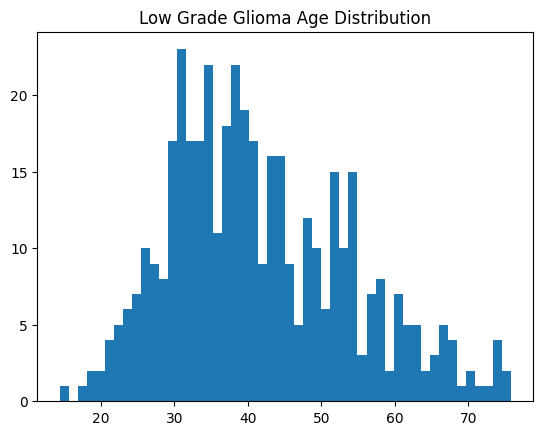

In [11]:
# Basic plot of low grade gliomas by age at diagnosis

age = data_new["age_at_diagnosis"]
plt.hist(age, bins = 50)
plt.title('Low Grade Glioma Age Distribution')
plt.show()


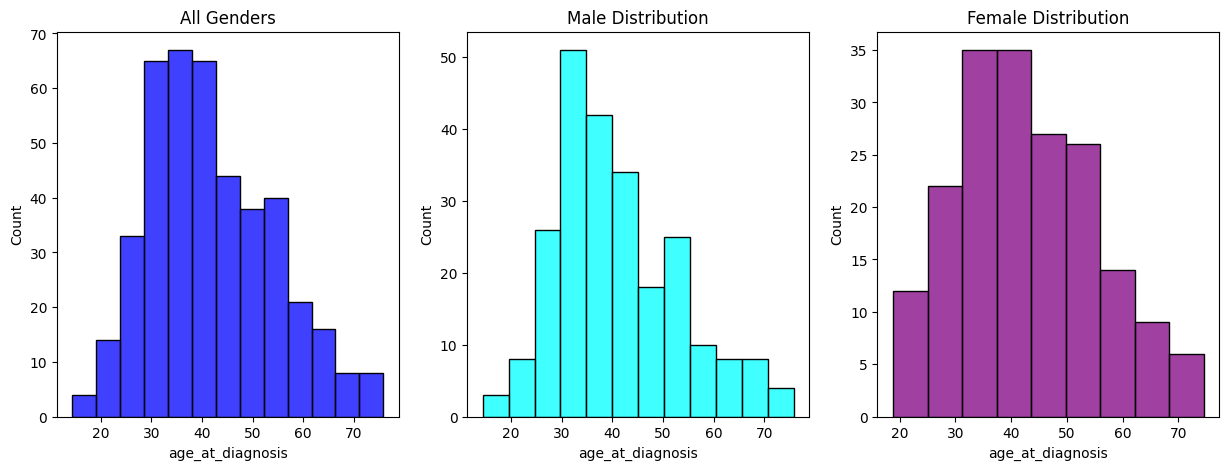

In [12]:
# Distribution by Gender using Seaborn

fig , ax = plt.subplots(1,3, figsize = (15,5))

gender_male = data_new.query("gender == 'male'")["age_at_diagnosis"]
gender_female = data_new.query("gender == 'female'")["age_at_diagnosis"]
age = data_new["age_at_diagnosis"]

sns.histplot(age , ax = ax[0] , color = 'blue').set_title('All Genders' , fontsize = 12)
sns.histplot(gender_male , ax = ax[1] , color = 'cyan').set_title('Male Distribution' , fontsize = 12)
sns.histplot(gender_female , ax = ax[2] , color = 'purple').set_title('Female Distribution' , fontsize = 12)

plt.show()

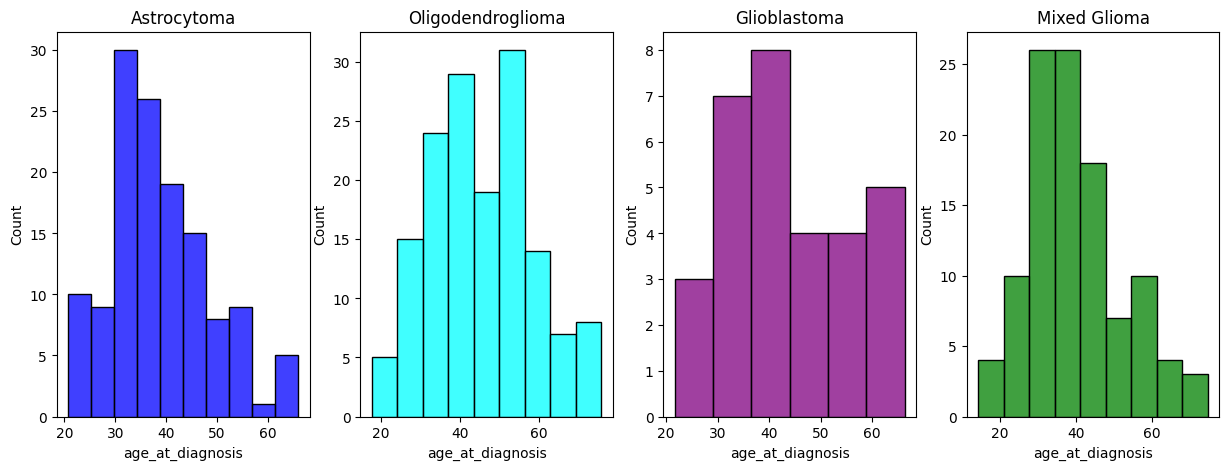

In [13]:
# Age at diagnosis distribution by glioma type (primary diagnosis)

fig , ax = plt.subplots(1,4, figsize = (15,5))

astrocytoma = data_new.query("primary_diagnosis == 'Astrocytoma, NOS' | primary_diagnosis == 'Astrocytoma, anaplastic'")["age_at_diagnosis"]
oligodendroglioma = data_new.query("primary_diagnosis == 'Oligodendroglioma, NOS' | primary_diagnosis == 'Oligodendroglioma, anaplastic'")["age_at_diagnosis"]
glioblastoma = data_new.query("primary_diagnosis == 'Glioblastoma'")["age_at_diagnosis"]
mixed_glioma = data_new.query("primary_diagnosis == 'Mixed glioma'")["age_at_diagnosis"]

sns.histplot(astrocytoma , ax = ax[0] , color = 'blue').set_title('Astrocytoma' , fontsize = 12)
sns.histplot(oligodendroglioma , ax = ax[1] , color = 'cyan').set_title('Oligodendroglioma' , fontsize = 12)
sns.histplot(glioblastoma , ax = ax[2] , color = 'purple').set_title('Glioblastoma' , fontsize = 12)
sns.histplot(mixed_glioma , ax = ax[3] , color = 'green').set_title('Mixed Glioma' , fontsize = 12)

plt.show()

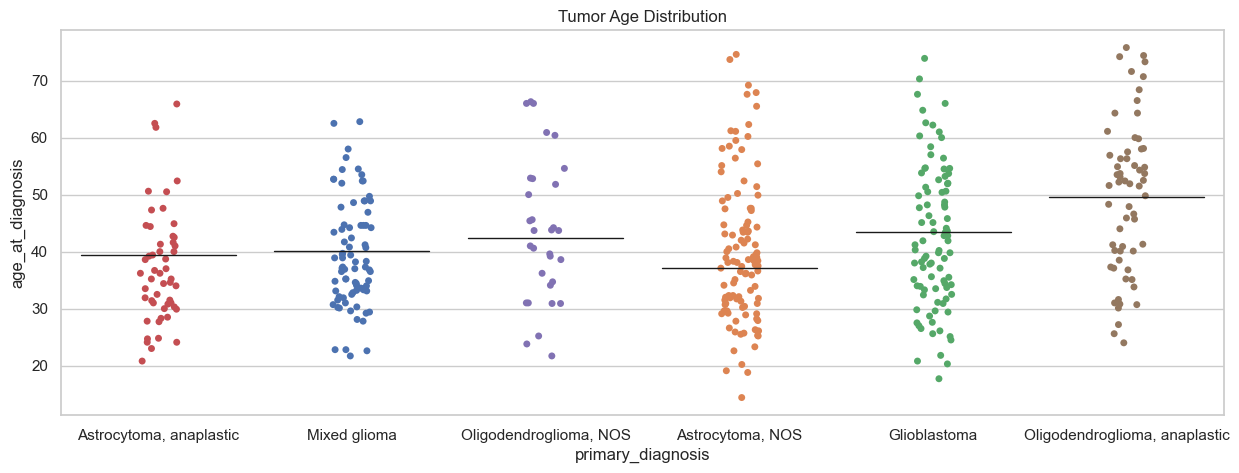

In [14]:
# Stripplot of Age by Primary Diagnosis

sns.set(style="whitegrid")
fig , ax = plt.subplots(1,1, figsize = (15,5))
  
# Seaborn stripplot w/ order by glioma type from left to right
ax = sns.stripplot(x='primary_diagnosis', y='age_at_diagnosis', hue="primary_diagnosis", data=data_new, legend=False, jitter=0.1, 
                   order=['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Mixed glioma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic'])
  
# Title for plot
plt.title('Tumor Age Distribution')

# Add mean line to plot
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="primary_diagnosis",
            y="age_at_diagnosis",
            data=data_new,
            showfliers=False,
            showbox=False,
            showcaps=False)
  
# Draw plot
plt.show()

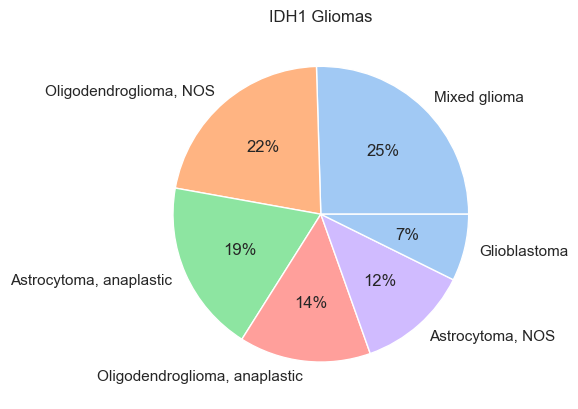

In [15]:
# Pie chart showing distribution of primary diagnosis

colors = sns.color_palette('pastel')[0:5]
data_diag = data_new["primary_diagnosis"]

plt.pie(data_diag.value_counts(), labels = data_diag.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("IDH1 Gliomas", fontsize=12);
plt.show()

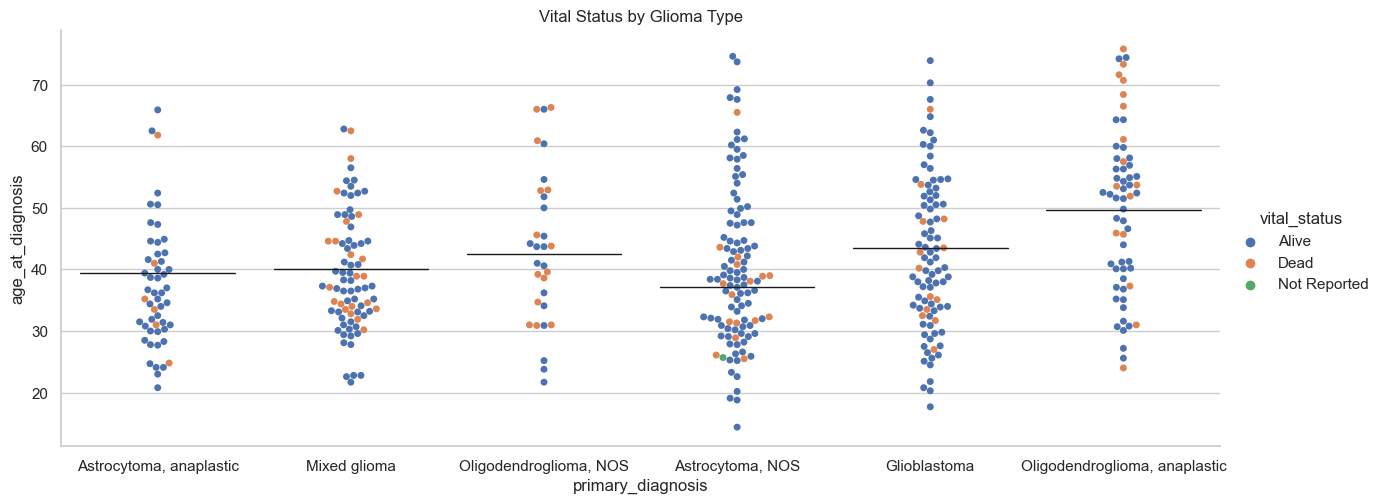

In [16]:
# Category Plot of Age and Vital Status by Primary Diagnosis

sns.set(style="whitegrid")
  
# Seaborn catplot w/ order by glioma type from left to right
ax = sns.catplot(data=data_new, kind="swarm", x='primary_diagnosis', y='age_at_diagnosis', hue="vital_status", legend=True, height=5, aspect=2.5,
                   order=['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Mixed glioma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic'])

# Add mean line to plot
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="primary_diagnosis",
            y="age_at_diagnosis",
            data=data_new,
            showfliers=False,
            showbox=False,
            showcaps=False)

# Title for plot
plt.title('Vital Status by Glioma Type')
  
# Draw plot
plt.show()

In [17]:
# Compare vital_status based on primary_diagnosis

# Create dataframe with counts based on vital_status and grouped by primary_diagnosis
data_summary = data_new[["primary_diagnosis", "vital_status"]].groupby("primary_diagnosis").value_counts().reset_index(name='count')

# Calculate percentages by primary_diagnosis and truncate to two decimal places
data_summary['percent'] = 100 * (data_summary['count'] / data_summary.groupby('primary_diagnosis')['count'].transform('sum'))
data_summary['percent'] = ((data_summary['percent']*100).astype(int).astype(float))/100

data_summary


,primary_diagnosis,vital_status,count,percent
0,"Astrocytoma, NOS",Alive,46,88.46
1,"Astrocytoma, NOS",Dead,6,11.53
2,"Astrocytoma, anaplastic",Alive,59,73.75
3,"Astrocytoma, anaplastic",Dead,21,26.25
4,Glioblastoma,Alive,17,54.83
5,Glioblastoma,Dead,14,45.16
6,Mixed glioma,Alive,91,84.25
7,Mixed glioma,Dead,16,14.81
8,Mixed glioma,Not Reported,1,0.92
9,"Oligodendroglioma, NOS",Alive,79,85.86


In [18]:
# OPTIONAL: Can further breakdown by gender and also do analysis of time to death.
# As the GDC sample size is small, any conclusions would be low confidence.